# Calculating Zonal Statistics

- In this episode, the focus is on calculating **zonal statistics based on crop types**.
- Zones are often provided within a single vector dataset, identified by vector attributes. Example: Crop field polygon dataset used in previous episodes. **Fields with the same crop type** can be identified as a **zone** (multiple zones within one vector dataset).
- Steps:
  1. Identify zones from the vector data.
  2. Rasterize the vector zones.
  3. Calculate zonal statistics for **ndvi** over the rasterized zones.
- Required files
  1. fields_cropped.shp
  2. NDVI.tif

## Making vector and raster data compatible

In [1]:
# Import the library for raster operation
import rioxarray

# Open ndvi file. Then, squeeze to reduce the dimension of data.
ndvi = rioxarray.open_rasterio("NDVI.tif").squeeze()

In [2]:
ndvi

<xarray.DataArray (y: 500, x: 500)> Size: 1MB
[250000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 4kB 6.29e+05 6.29e+05 ... 6.39e+05 6.39e+05
  * y            (y) float64 4kB 5.814e+06 5.814e+06 ... 5.804e+06 5.804e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [3]:
# Import geopandas
import geopandas as gpd

# Open the shapefile of fields cropped from Day-1
fields = gpd.read_file('fields_cropped.shp')

In [4]:
fields

,category,gewas,gewascode,jaar,status,geometry
0,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((120154.932 495930.341, 120154.309 49..."
1,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((120101.483 496378.781, 120100.177 49..."
2,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((119858.185 496057.345, 119855.745 49..."
3,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((120168.354 496651.174, 120160.995 49..."
4,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((119944.018 496061.229, 119924.704 49..."
...,...,...,...,...,...,...
4867,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((133371.14 492631.152, 133363.203 492..."
4868,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((133422.246 492887.057, 133420.13 492..."
4869,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((133554.659 492738.186, 133554.924 49..."
4870,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((133434.981 492748.79, 133430.854 492..."


In [5]:
ndvi.rio.crs

CRS.from_epsg(32631)

In [7]:
# Make CRS uniform between raster and vector data
fields_utm = fields.to_crs(ndvi.rio.crs)

## Rasterize vector data

In [8]:
# Rasterize the vector data
# - List values of polygon and the unique code in vector file 
fields_utm

,category,gewas,gewascode,jaar,status,geometry
0,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((627394.386 5812746.538, 627393.681 5..."
1,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((627326.17 5813192.913, 627324.734 58..."
2,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((627093.646 5812863.661, 627090.972 5..."
3,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((627384.004 5813467.33, 627376.549 58..."
4,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((627179.293 5812870.376, 627160.747 5..."
...,...,...,...,...,...,...
4867,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((640710.959 5809885.718, 640703.03 58..."
4868,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((640753.587 5810143.151, 640751.454 5..."
4869,Grasland,"Grasland, blijvend",265,2020,Definitief,"POLYGON ((640890.832 5809998.743, 640892.271 5..."
4870,Grasland,"Grasland, natuurlijk. Hoofdfunctie landbouw.",331,2020,Definitief,"POLYGON ((640770.878 5810005.39, 640766.767 58..."


In [9]:
# List all the columns required for rasterization
geom = fields_utm[['geometry', 'gewascode']].values.tolist()
geom

[[<POLYGON ((627394.386 5812746.538, 627393.681 5812749.022, 627384.063 581279...>,
  265],
 [<POLYGON ((627326.17 5813192.913, 627324.734 5813196.828, 627324.11 5813203....>,
  265],
 [<POLYGON ((627093.646 5812863.661, 627090.972 5812870.702, 627076.762 581286...>,
  265],
 [<POLYGON ((627384.004 5813467.33, 627376.549 5813470.117, 627385.233 5813495...>,
  265],
 [<POLYGON ((627179.293 5812870.376, 627160.747 5812846.868, 627159.505 581284...>,
  331],
 [<POLYGON ((627419.816 5812765.254, 627416.356 5812766.811, 627413.1 5812769....>,
  265],
 [<POLYGON ((627358.683 5813335.376, 627362.871 5813352.853, 627370.175 581337...>,
  265],
 [<POLYGON ((627423.06 5813550.358, 627421.409 5813550.392, 627427.293 5813568...>,
  265],
 [<POLYGON ((627191.219 5813028.547, 627189.596 5813028.866, 627186.64 5813029...>,
  265],
 [<POLYGON ((627349.601 5813329.836, 627343.37 5813330.159, 627341.775 5813330...>,
  265],
 [<POLYGON ((627809.311 5811941.534, 627793.366 5811967.477, 627778.317 581199..

In [10]:
# Rasterize the list of polygon with gewascode as value
from rasterio import features
# Do rasterization. Parameters: list of geometry, shape of the raster (dimension), transformation function
fields_rasterized = features.rasterize(geom, out_shape=ndvi.shape, transform=ndvi.rio.transform())

In [11]:
# Inspect the information from the rasterized shape
import numpy as np
# Print the shape of rasterized vector
print(fields_rasterized.shape)
# Print the unique value exist on rasterized vector
print(np.unique(fields_rasterized))

(500, 500)
[  0 259 265 266 331 332 335 863]


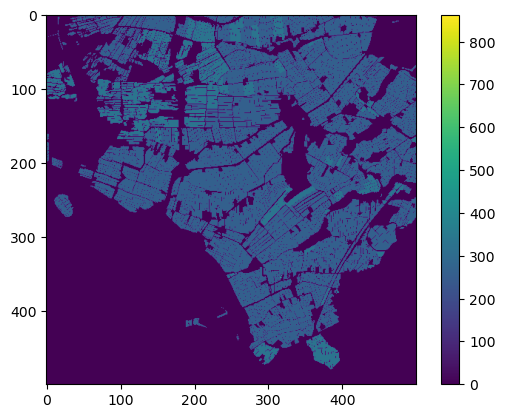

In [12]:
# Plot the rasterized vector
# - Import pyplot
from matplotlib import pyplot as plt
# - Show the image of rasterized vector
plt.imshow(fields_rasterized)
# - Show the colorbar
plt.colorbar()

In [13]:
type(fields_rasterized)

numpy.ndarray

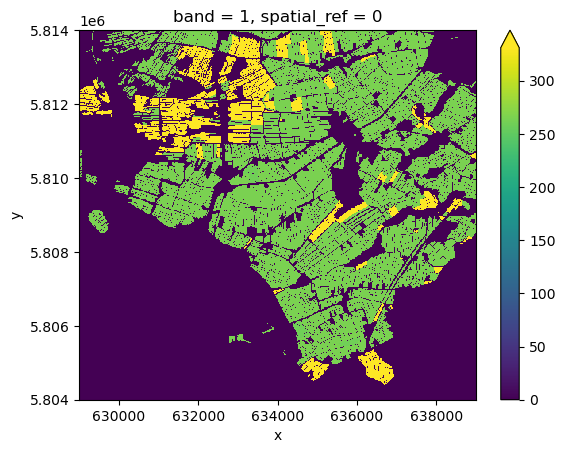

In [14]:
# Convert numpy ndarray to be xarray for convinience of operation
# - Import xarray
import xarray as xr
# - Copy the shape and metadata from the NDVI data
fields_rasterized_xarr = ndvi.copy()
# - Change the data with the rasterized vector
fields_rasterized_xarr.data = fields_rasterized

# Visualize using built-in plot function (no need to explicitely using matplotlib)
fields_rasterized_xarr.plot(robust=True)

## Calculate zonal statistics

In [15]:
# Calculate zonal statistics
# - Import xrspatial library for calculating zonal statistics
from xrspatial import zonal_stats

# Calculate the zonal stats of ndvi given the gewaascode as zone category
zonal_stats(fields_rasterized_xarr, ndvi)

,zone,mean,max,min,sum,std,var,count
0,0,0.266528,0.999579,-0.998648,38887.554688,0.409970,0.168075,145904.0
1,259,0.520282,0.885242,0.289196,449.003052,0.111205,0.012366,863.0
2,265,0.775609,0.925955,0.060755,66478.976562,0.091089,0.008297,85712.0
3,266,0.794128,0.918048,0.544686,1037.925781,0.074009,0.005477,1307.0
4,331,0.703056,0.905304,0.142226,10725.819336,0.102255,0.010456,15256.0
5,332,0.681699,0.849158,0.178113,321.080261,0.123633,0.015285,471.0
6,335,0.648063,0.865804,0.239661,313.662598,0.146582,0.021486,484.0
7,863,0.388575,0.510572,0.185987,1.165724,0.144245,0.020807,3.0


Let’s calculate NDVI zonal statistics for the different zones as classified by ndvi_classified in the previous episode.

1. Load both raster datasets: NDVI.tif and NDVI_classified.tif.

2. Then, calculate zonal statistics for each class_bins. Inspect the output of the zonal_stats function.

In [16]:
# Load the ndvi and ndvi_classified
ndvi = rioxarray.open_rasterio("NDVI.tif").squeeze()
ndvi_classified = rioxarray.open_rasterio("NDVI_classified.tif").squeeze()

In [17]:
zonal_stats(ndvi_classified, ndvi)

,zone,mean,max,min,sum,std,var,count
0,1,-0.355660,-0.000257,-0.998648,-12838.253906,0.145916,0.021291,36097.0
1,2,0.110731,0.199839,0.000000,1754.752441,0.055864,0.003121,15847.0
2,3,0.507998,0.700000,0.200000,50410.167969,0.140193,0.019654,99233.0
3,4,0.798281,0.999579,0.700025,78888.523438,0.051730,0.002676,98823.0


In [19]:
type(ndvi_classified)

xarray.core.dataarray.DataArray